# BioCreative II Gene Mention (GM) Task - Part 2

For more information: https://biocreative.bioinformatics.udel.edu/tasks/biocreative-ii/task-1a-gene-mention-tagging/


Bio-medical journal articles have a very rich vocabulary. One side-effect for our model is that any unseen text is likely to have a high number of OOV (unknown) words, including the test set. 

Another issue is that the Keras embeddings are trained on words as discrete terms, not taking into account similarities in word morphology. In the case of gene names, we may be missing common suffixes or roots that are clues to word semantics.

This version of the model attempts to address both issues by using [FastText](https://fasttext.cc). *fastText* embeddings are similar to word2vec, but can be trained including subword (i.e. *char-grams*) information. For domains where we may believe a word's morphology may provide clues to its semantics, this may be a benefit. In fact, many of the original participants in BCII engineered features to CRF classifiers based on word-shape and suffixes - a common approach in NLP. The other advantage is that we can produce embeddings for OOV words based on subword information!

# Setup

The following sections are mostly the same. One important difference is that the padded text sequences are pre-processed by a pretrained fastText model, and the (now 2-dimensional) embeddings are provided as input to the network.

The embedding model was trained used the same PMC Open Access dataset used to train the GloVe embeddings shown in the first model.


In [1]:
from bc2reader import BC2Reader
import os

train_home = '/home/ryan/Development/deep-learn-bio-nlp/bc2/bc2geneMention/train'
reader = BC2Reader('{0}/train.in'.format(train_home), '{0}/GENE.eval'.format(train_home))
reader.convert('{0}/train.json'.format(train_home))
# vocab = [a for a, b in reader.vocab.items() if b >= 3] # Let's see the word at least 3 times
vocab = [a for a, _ in reader.vocab.items()] 

In [2]:
print("Size of vocabulary: {0}".format(len(vocab)))

Size of vocabulary: 36655


This will generate a JSON file with a more familiar format. Here is the first sentence in our BIO format:

In [3]:
import json
with open('{0}/train.json'.format(train_home), 'r') as json_file:
    training_data = json.load(json_file)
    print(training_data[0])

['P00001606T0076', ['Comparison', 'with', 'alkaline', 'phosphatases', 'and', '5-nucleotidase'], ['O', 'O', 'B', 'I', 'O', 'B']]


This may be easier to read if we zip together the tokens and labels:

In [4]:
print(list(zip(training_data[0][1], training_data[0][2])))

[('Comparison', 'O'), ('with', 'O'), ('alkaline', 'B'), ('phosphatases', 'I'), ('and', 'O'), ('5-nucleotidase', 'B')]


## Prepare the test data

The same _bc2reader_ is used to format the test file.

In [5]:
test_home = '/home/ryan/Development/deep-learn-bio-nlp/bc2/bc2GNandGMgold_Subs/sourceforgeDistrib-22-Sept-07/genemention/BC2GM/test'
reader = BC2Reader('{0}/test.in'.format(test_home), '{0}/GENE.eval'.format(test_home))
reader.convert('{0}/test.json'.format(test_home))

with open('{0}/test.json'.format(test_home), 'r') as json_file:
    test_data = json.load(json_file)
    print(test_data[0])

['BC2GM000008491', ['Phenotypic', 'analysis', 'demonstrates', 'that', 'trio', 'and', 'Abl', 'cooperate', 'in', 'regulating', 'axon', 'outgrowth', 'in', 'the', 'embryonic', 'central', 'nervous', 'system', '(', 'CNS', ')', '.'], ['O', 'O', 'O', 'O', 'B', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]


## Setup the model constants

In [6]:
import numpy as np
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, GRU, ConvLSTM2D
from keras.layers import TimeDistributed, Dropout, Bidirectional

max_len = 150
lstm_n = 256
batch_n = 25
epoch_n = 5

word2idx = {word: idx + 2 for idx, word in enumerate(vocab)}
word2idx['_PAD_'] = 0
word2idx['_OOV_'] = 1

tag2idx = {'O': 0, 'B': 1, 'I': 2}
n_tags = len(tag2idx)

X = [[m for m in row[1]] for row in training_data]
y = [[tag2idx.get(m, 0) for m in row[2]] for row in training_data]

# Get an idea about class dist.
cnt = Counter()
for labels in y:
    cnt.update(labels)
cnt_total = sum([v for _, v in cnt.items()])
for k, v in cnt.items():
    print("{0}: {1}".format(k, (100 * v)/cnt_total))
        
# Get a general idea of the lengths of the sequences:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in X], bins=50)
plt.show()

X_test = [[m for m in row[1]] for row in test_data]
y_test = [[tag2idx.get(m, 1) for m in row[2]] for row in test_data]

X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value='_PAD_', dtype=object)
X_test = pad_sequences(maxlen=max_len, sequences=X_test, padding="post", value='_PAD_', dtype=object)
 
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx['O']) 
y = [to_categorical(i, num_classes=n_tags) for i in y]
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx['O']) 
y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]


Using TensorFlow backend.


0: 90.33062421615003
1: 4.387337922044577
2: 5.282037861805398


<Figure size 640x480 with 1 Axes>

### FastText

Although not needed, it is possible to create a weight matrix for an Embedding layer directly from the pre-trained fastText model and vocabulary (as shown below). Rather than take this approach, the cells below simply pre-process any input text sequences using the fastText model. This allows us to better handle OOV terms in any unseen data sets.

```python
import fasttext
embedding_dim = 100

fasttext_model = fasttext.load_model('./ftmodel.bin')

embedding_matrix = np.zeros((len(word2idx) + 1, embedding_dim))
for word, i in word2idx.items():
    embedding_vector = fasttext_model[word].tolist()
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
```

## Text pre-processing



In [8]:
import fasttext
embedding_dim = 100

fasttext_model = fasttext.load_model('./ftmodel.bin')

X = [[fasttext_model[m] for m in sent] for sent in X]
X_test = [[fasttext_model[m] for m in sent] for sent in X_test]

X = np.array(X)
X_test = np.array(X_test)

## Creating the model

This is the first version of the model using a single Bidirectional LSTM layer. The *optimizer* has been changed to `rmsprop`. Note that since the translation from words to embeddings has already been done, the `Input` shape now has an extra dimension (the embedding size) and the Embedding layer has been removed.

In [9]:
_input = Input(shape=(max_len, 100))

model = Bidirectional(LSTM(units=lstm_n, return_sequences=True, dropout=0.2, recurrent_dropout=0.1))(_input)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)
model = Model(_input, out)
 
model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 512)          731136    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 150, 3)            1539      
Total params: 732,675
Trainable params: 732,675
Non-trainable params: 0
_________________________________________________________________


### Fit the model

In [10]:
history = model.fit(X, np.array(y), batch_size=batch_n, epochs=epoch_n, validation_split=0.05, verbose=1)

Instructions for updating:
Use tf.cast instead.


Train on 14250 samples, validate on 750 samples
Epoch 1/5
14250/14250 [==============================] - 115s 8ms/step - loss: 0.0358 - categorical_accuracy: 0.9861 - val_loss: 0.0209 - val_categorical_accuracy: 0.9928
Epoch 2/5
14250/14250 [==============================] - 114s 8ms/step - loss: 0.0237 - categorical_accuracy: 0.9908 - val_loss: 0.0159 - val_categorical_accuracy: 0.9948
Epoch 3/5
14250/14250 [==============================] - 114s 8ms/step - loss: 0.0207 - categorical_accuracy: 0.9920 - val_loss: 0.0159 - val_categorical_accuracy: 0.9949
Epoch 4/5
14250/14250 [==============================] - 114s 8ms/step - loss: 0.0185 - categorical_accuracy: 0.9928 - val_loss: 0.0151 - val_categorical_accuracy: 0.9949
Epoch 5/5
14250/14250 [==============================] - 114s 8ms/step - loss: 0.0170 - categorical_accuracy: 0.9934 - val_loss: 0.0142 - val_categorical_accuracy: 0.9951


### Plot and review the training history

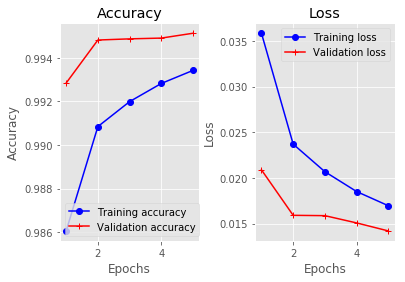

In [11]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r+-', label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r+-', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Test set evaluation

In [12]:
pred = model.predict(X_test)
print(pred.shape)
pred_index = np.argmax(pred, axis=-1)
print(pred_index.shape)

(5000, 150, 3)
(5000, 150)


The following code converts the output of the tagger (where each term is BIO tagged) back to the original BCII format.

In [13]:
from collections import defaultdict

with open('{0}/ryan_eval_2.eval'.format(test_home), 'w') as mention_fh:
    for i, row in enumerate(test_data):
        sent_id = row[0]
        tokens = row[1][:max_len]
        running_count = 0
        buffer = {'s':None, 'e':None, 'text':[]}
        for j, token in enumerate(tokens):
            tag = pred_index[i][j]
            if tag == 1:
                buffer.get('text').append(token)
                buffer['s'] = running_count
                buffer['e'] = running_count + len(token) - 1
            elif tag == 2:
                buffer.get('text').append(token)
                buffer['e'] = running_count + len(token) - 1
            elif tag == 0 and buffer.get('s'):
                text = ' '.join(buffer.get('text'))
                mention_fh.write('{0}|{1} {2}|{3}\n'.format(sent_id, buffer.get('s'), buffer.get('e'), text))
                buffer = {'s':None, 'e':None, 'text':[]}
            running_count += len(token)

Using the BCII evaluation script:

    TP: 4744
    FP: 1197
    FN: 1587
    Precision: 0.798518767884195 Recall: 0.749328700047386 F: 0.773142112125163

This F score is a big improvement (5 pts), with a significant increase in recall. Note that the model is trained an extra epoch even though the validation loss seems to bottom out. This seems to improve the model recall without significant reduction in precision -- My guess is that this is due to the large class imbalance.

This score places this model above the bottom 5 of 19 participants in the 2008 competition. All the more impressive since _only_ the training data was used (what the task describes as a _closed_ system), not using any outside BioNLP resources. 
